# **PLEASE MAKE YOUR OWN COPY OF THIS NOTEBOOK**

# CIS 5450 Homework 2: SQL (Spring 2025)

**Due: Sunday, March 2nd, 10:00 PM EST**

**Total Points: 100 (69 Auto-graded + 31 Manually Graded)**

Welcome to Homework 2! By now, you should be familiar with the world of data science and the Pandas library. This assignment focuses on helping you get to grips with a new tool: SQL.

Through this homework, we will be working with SQL and DuckDB by exploring a [Yelp](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/versions/6) dataset containing business, checkin, tip, and user data. We will also conduct some text analysis.

 <!-- We will finish off the homework with some text analysis. -->

We are introducing a lot of new things in this homework, and this is often where students start to get lost. Thus, we **strongly** encourage you to review the slides/material as you work through this assignment.

**Before you begin:**
- Be sure to click "Copy to Drive" to make sure you're working on your own personal version of the homework
- Check the **pinned FAQ post** on Ed for updates! If you have been stuck, chances are other students have also faced similar problems.



## Part 0: Libraries and Set Up Jargon (The usual wall of imports)
Run but do *not* edit these cells.

In [ ]:
%set_env HW_ID=cis5450_sp25_HW2

env: HW_ID=cis5450_sp25_HW2


In [ ]:
%%capture
!pip install penngrader-client

In [ ]:
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install geopy
!pip install -U kaleido
!pip3 install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.38
    Uninstalling SQLAlchemy-2.0.38:
      Successfully uninstalled SQLAlchemy-2.0.38
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=7010bef90c6a54d00c6dc53de325b2b4b1e3a0f12847a1853cb192e2a7b8094e
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00


In [ ]:
from penngrader.grader import *
import pandas as pd
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
import pandasql as ps #SQL on Pandas Dataframe
import duckdb

from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import math
import re
import json
import os
from collections import Counter
import random

In [ ]:
# Five datasets we're using
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_business.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_checkin.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_tip.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_user.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/hotel_reviews.csv

--2025-02-27 03:48:09--  https://storage.googleapis.com/penn-cis5450/yelp_business.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.207, 172.253.63.207, 142.250.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31760674 (30M) [text/csv]
Saving to: ‘yelp_business.csv’

yelp_business.csv   100%[===================>]  30.29M   176MB/s    in 0.2s    

2025-02-27 03:48:09 (176 MB/s) - ‘yelp_business.csv’ saved [31760674/31760674]

--2025-02-27 03:48:09--  https://storage.googleapis.com/penn-cis5450/yelp_checkin.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.207, 172.253.63.207, 142.250.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135964892 (130M) [text/csv]
Saving to: ‘yelp_checkin.csv’

yelp_checkin.csv 

In [ ]:
print(pd.__version__ )

2.2.2


###Setting up PennGrader###

In [ ]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND

# YOUR PENN-ID GOES HERE AS AN INTEGER
STUDENT_ID = 999999999999

# You should also update this to a unique "secret" just for this homework, to
# authenticate this is YOUR submission
SECRET = STUDENT_ID

In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [ ]:
grader = PennGrader('notebook-config.yaml', "cis5450_sp25_HW2", STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 32402813

Make sure this correct or we will not be able to store your grade


We will use scores from Penn Grader to determine your grade. You will still need to submit your notebook so we can check for cheating and plagarism. Do not cheat.

**Note:** If you run Penn Grader after the due date for any question, your assignment will be marked late, even if you already had full points for the question before the deadline. To remedy this, if you're going to run your notebook after the deadline, either do not run the grading cells, or reinitialize the grader with an empty or clearly fake ID such as <code>999999999999</code> (please use 10+ digits to be clearly a fake <code>STUDENT_ID</code>)

# Yelp Dataset

<br>
<center><img src = "https://static-prod.adweek.com/wp-content/uploads/2021/08/YelpLogoAugust2021.jpg" width= "500" align ="center"/></center>
<br>



I'm sure you have used Yelp when searching for good restaurants or reliable local services, and with good reason. In this homework, we'll explore Yelp's extensive datasets to gain valuable insights into businesses and users on the platform. The data we will be using includes:

* Business: data about businesses listed on Yelp
* Check-in: data about check-ins made on businesses
* Tip: data about tips that users left for each business
* User: data about each user on Yelp including friends and number of reviews

We'll be parsing this data into dataframes and relations, and then exploring how to query and assemble the tables into results. We will primarily be using PandaSQL, but for some of the initial questions, we will ask you to perform the same operations in Pandas as well, so as to familiarize you with the differences and similarities of the two.

For the final part of this homework, we'll perform some text analysis on a hotel review dataset.

## Part 1: Load & Process our Datasets [12 points total]

Before we get into the data, we first need to load and clean our datasets.

# Metadata
You'll be working with four CSV files:
- `yelp_business.csv`
- `yelp_checkin.csv`
- `yelp_tip.csv`
- `yelp_user.csv`

The file `yelp_business.csv` contains data of businesses listed on Yelp such as name, address, stars, review count, etc.

The file `yelp_checkin.csv` contains check-in data for businesses including day, hour, and number of people.

The file `yelp_tip.csv` contains tips that each user left for each business.

The file `yelp_user.csv` contains data of each user such as name, review count, friends, start date of membership, and etc.


**TODO**:
* Load `yelp_business.csv` and save the data to a dataframe called `business_df`.
* Load `yelp_checkin.csv` and save the data to a dataframe called `checkin_df`.
* Load `yelp_tip.csv` and save the data to a dataframe called `tip_df`.
* Load `yelp_user.csv` and save the data to a dataframe called `user_df`.


In [ ]:
# TODO: Import the datasets to pandas dataframes -- make sure the dataframes are named correctly!
business_df = pd.read_csv('yelp_business.csv')
checkin_df = pd.read_csv('yelp_checkin.csv')
tip_df = pd.read_csv('yelp_tip.csv')
user_df = pd.read_csv('yelp_user.csv')

### 1.1 Data Preprocessing

Next, we are going to want to clean up our dataframes. We will start with cleaning up `business_df`.

#### 1.1.1 Cleaning `business_df` [4 points]

`.info()` gives us meaningful information regarding columns, their types, and the amount of nulls, based on which we can now clean our dataframe.

Perform these steps and save results on a new dataframe: `business_cleaned_df`

**TODO**:
* Copy `business_df` to the new dataframe called `business_cleaned_df`
* Remove extra quotation marks from the entries in the columns `name` and `address` in `business_cleaned_df`
* Convert the column `categories` into a list of strings
* Drop `neighborhood` column from `business_cleaned_df`
* Create a column called `is_restaurant` where the value is 1 if `'Restaurants'` is in the list in column `categories` and is 0 otherwise
* Standardize the city column using **regex** by removing extra spaces and capitalizing each word (e.g., "Las Vegas", "Las  Vegas", and "las vegas" should all be standardized to "Las Vegas"). Use `.strip()` to help remove extra spaces, and `.title()` to capitalize.
* Sort `business_cleaned_df` by `business_id` in an ascending order, and reset index as well in order to drop old indices
* Create a list called `business_category_list` containing all unique values found in column `categories` and sort the list in an alphabetical order.

After performing these steps, `business_cleaned_df` should have the following schema:

**Final Schema**:
>business_id | name | address | city | state | postal_code | latitude | longitude | stars | review_count | is_open | categories | is_restaurant
>--- | --- | --- |--- | --- | --- | --- |--- | --- | --- |--- |--- |---

### **NOTES: MAKE SURE TO ALWAYS RESET INDEX. OTHERWISE, YOU MIGHT GET AN INTERNAL SERVER ERROR WHEN RUNNING THE TEST CASES!!!**

In [ ]:
# View info of business_df
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   174567 non-null  object 
 1   name          174567 non-null  object 
 2   neighborhood  68015 non-null   object 
 3   address       174567 non-null  object 
 4   city          174566 non-null  object 
 5   state         174566 non-null  object 
 6   postal_code   173944 non-null  object 
 7   latitude      174566 non-null  float64
 8   longitude     174566 non-null  float64
 9   stars         174567 non-null  float64
 10  review_count  174567 non-null  int64  
 11  is_open       174567 non-null  int64  
 12  categories    174567 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 17.3+ MB


In [ ]:
# View first few rows of business_df
business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [ ]:
# TODO: Create a copy of business_df called  business_cleaned_df
business_cleaned_df = business_df.copy()

In [ ]:
# TODO: Remove extra quotations from name and address
business_cleaned_df['name'] = business_cleaned_df['name'].str.replace('"', '')
business_cleaned_df['address'] = business_cleaned_df['address'].str.replace('"', '')

In [ ]:
# TODO: Convert categories into a list of strings
business_cleaned_df['categories'] = business_cleaned_df['categories'].str.split(';')

In [ ]:
# TODO: Drop neighborhood column
business_cleaned_df = business_cleaned_df.drop(columns = ['neighborhood'])

In [ ]:
# TODO: Create a column called is_restaurant where the value is 1 if 'Restaurants' is within the list in the column categories and is 0 otherwise
business_cleaned_df['is_restaurant'] = business_cleaned_df['categories'].apply(lambda x: 1 if 'Restaurants' in x else 0)

In [ ]:
# TODO: Standardize the city column using regex (remove extra spaces and capitalizing words)
business_cleaned_df['city'] = business_cleaned_df['city'].str.title().str.strip()

In [ ]:
# TODO: Sort business_id by ascending order
business_cleaned_df = business_cleaned_df.sort_values(by = 'business_id', ascending = True).reset_index(drop = True)

In [ ]:
# TODO: Create a list called business_category_list containing all unique values found in column categories and sort the list in an alphabetical order
business_category_list = sorted(list(set([item for sublist in business_cleaned_df['categories'] for item in sublist])))

In [ ]:
# 4 points
grader.grade(test_case_id = 'test_cleaning_business', answer = (len(business_category_list), business_cleaned_df.head(5)))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.2 Cleaning `checkin_df` [3 points]

We will inspect `checkin_df` through the following steps:

**TODO**:
* Copy `checkin_df` to the new dataframe called `checkin_cleaned_df`
* Inspect the values in `weekday` column. Store the number of unique values for the column `weekday` in the variable called `weekday_count_checkin`
* Inspect the values in `hour` column. Store the number of unique values for the column `hour` in the variable called `hour_count_checkin`
* We would like to know the maximum TOTAL number of check-ins received by a business in the dataframe. Store this value in the variable called `max_checkin_single`

After performing these steps, `checkin_cleaned_df` should have the following schema (should be the same as `checkin_df`):

**Final Schema**:
>business_id | weekday | hour | checkins
>--- | --- | --- |---

In [ ]:
# View info of checkin_df
checkin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911218 entries, 0 to 3911217
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   business_id  object
 1   weekday      object
 2   hour         object
 3   checkins     int64 
dtypes: int64(1), object(3)
memory usage: 119.4+ MB


In [ ]:
# TODO: Create a copy of checkin_df called  checkin_cleaned_df
checkin_cleaned_df = checkin_df.copy()

In [ ]:
# TODO: View checkin_cleaned_df
checkin_cleaned_df.head()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


In [ ]:
# TODO: Store the number of unique values for the column weekday in the variable called weekday_count_checkin
weekday_count_checkin = checkin_cleaned_df['weekday'].nunique()

In [ ]:
# TODO: Store the number of unique values for the column hour in the variable called hour_count_checkin
hour_count_checkin = checkin_cleaned_df['hour'].nunique()

In [ ]:
# TODO: Store the maximum number of check-ins for a single business in the variable called max_checkin_single
max_checkin_single = checkin_cleaned_df.groupby('business_id')['checkins'].sum().max()

In [ ]:
# 3 points
grader.grade(test_case_id = 'test_cleaning_checkin', answer = (weekday_count_checkin, hour_count_checkin, max_checkin_single))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.3 Cleaning `tip_df` [2 points]

We will clean `tip_df` through the following steps:

**TODO**:
* Copy `tip_df` to the new dataframe called `tip_cleaned_df`
* Drop all rows with NA
* Convert the data type in `date` column from string to `datetime64[ns]` (Use default format: `'%Y-%m-%d'`)
* Sort `tip_cleaned_df` by `business_id` and `user_id` in an ascending order and reset index

After performing these steps, `tip_cleaned_df` should have the following schema (should be the same as `tip_df`):

**Final Schema**:
>text | date | likes | business_id | user_id
>--- | --- | --- |--- |---

In [ ]:
# View info of tip_df
tip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098324 entries, 0 to 1098323
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   text         1098319 non-null  object
 1   date         1098324 non-null  object
 2   likes        1098324 non-null  int64 
 3   business_id  1098324 non-null  object
 4   user_id      1098324 non-null  object
dtypes: int64(1), object(4)
memory usage: 41.9+ MB


In [ ]:
# TODO: Create a copy of tip_df called tip_cleaned_df
tip_cleaned_df = tip_df.copy()

In [ ]:
# TODO: Drop rows with NA
tip_cleaned_df = tip_cleaned_df.dropna()

In [ ]:
# TODO: Convert the data in date column from string to datetime64[ns]
tip_cleaned_df['date'] = pd.to_datetime(tip_cleaned_df['date'])

In [ ]:
# TODO: Sort tip_cleaned_df by business_id and user_id in an ascending order and reset index
tip_cleaned_df = tip_cleaned_df.sort_values(by = ['business_id', 'user_id'], ascending = True).reset_index(drop = True)

In [ ]:
# 2 points
grader.grade(test_case_id = 'test_cleaning_tip', answer = (tip_cleaned_df.head(5), len(tip_cleaned_df)))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.4 Cleaning `user_df` [3 points]

To understand what each column means, please refer to [this documentation](https://www.yelp.com/dataset/documentation/main) (Note that the original datasets were in JSON format).

Perform these steps and save results on a new dataframe: `user_cleaned_df`

**TODO**:
* Copy `user_df` to the new dataframe called `user_cleaned_df`
* Convert the type of the `friends` column to string, stripping excess spaces, and then convert the `friends` column to a list of strings.
* Create a column called `has_friend` which contains a value of 1 if the user has at least 1 friends and contains a value of 0 otherwise (read note below)
* Keep only these columns `user_cleaned_df`: `user_id, name, review_count, yelping_since, friends, elite, average_stars, has_friend`. (i.e. drop all others)
* Sort `user_cleaned_df` by `user_id` in an ascending order and reset index

After performing these steps, `user_cleaned_df` should have the following schema:

**Final Schema**:
>user_id | name | review_count | yelping_since | friends | elite | average_stars | has_friend
>--- | --- | --- |--- | --- | --- |--- |---


**Notes:**
* Do not convert the `friends` column into a list of strings since the table is very large, and performing such an operation could lead to a depletion of your RAM. We will address this column later, but only on a smaller subset of the table.
* `'None'` should not be interpreted as `NA` but rather a string `'None'`. After converting `'friends'` to type string, you should check for both `'None'` and `'nan'` with that spelling as indicators of having no friends.

In [ ]:
# View info of user_df
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326100 entries, 0 to 1326099
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             1326100 non-null  object 
 1   name                1325585 non-null  object 
 2   review_count        1326100 non-null  int64  
 3   yelping_since       1326100 non-null  object 
 4   friends             760007 non-null   object 
 5   useful              1326100 non-null  int64  
 6   funny               1326100 non-null  int64  
 7   cool                1326100 non-null  int64  
 8   fans                1326100 non-null  int64  
 9   elite               60818 non-null    object 
 10  average_stars       1326100 non-null  float64
 11  compliment_hot      1326100 non-null  int64  
 12  compliment_more     1326100 non-null  int64  
 13  compliment_profile  1326100 non-null  int64  
 14  compliment_cute     1326100 non-null  int64  
 15  compliment_list

In [ ]:
# TODO: Create a copy of user_df called user_cleaned_df
user_cleaned_df = user_df.copy()

In [ ]:
# TODO: Strip the friends column of excess spaces and convert type to string.
user_cleaned_df['friends'] = user_cleaned_df['friends'].str.strip().astype(str)

In [ ]:
# TODO: Create a column called has_friend which contains a value of 1 if the user has friends and 0 otherwise
user_cleaned_df['has_friend'] = user_cleaned_df['friends'].apply(lambda x: 1 if x != 'None' and x != 'nan' else 0)

In [ ]:
# TODO: Drop unwanted columns
user_cleaned_df = user_cleaned_df[['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'elite', 'average_stars', 'has_friend']]

In [ ]:
# TODO: Sort by user_id in an ascending order
user_cleaned_df = user_cleaned_df.sort_values(by = 'user_id', ascending = True).reset_index(drop = True)

In [ ]:
# 3 points
grader.grade(test_case_id = 'test_cleaning_user', answer = (user_cleaned_df.head(5), len(user_cleaned_df)))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 2: Exploring the Data with DuckDB and SQL [63 points total]

### 👇👇👇 IMPORTANT: Pay VERY CLOSE attention to this style guide! 👇👇👇

The typical flow to use duckdb or pandasql (aliased as `ps`) is as follows:
1. Write a SQL query in the form of a string
    - **ALL SQL CLAUSES (`SELECT`, `FROM`, `WHERE`...) SHOULD BE CAPITALIZED!!!**. We would be checking the usage of certain clauses in your queries for partial credits and **they must be capitalized for you to receive credits**.
    - **String Syntax:** use triple quotes `"""<your query>"""` to write multi-line strings
    - **Aliases are your friend:** if there are very long table names or you find yourself needed to declare the source (common during join tasks), it's almost always optimal to alias your tables with short INTUITIVE alias names
    - **New Clauses New Line:** each of the main SQL clauses (`SELECT`, `FROM`, `WHERE`, etc.) should begin on a new line
    - **Use Indentation:** if there are many components for a single clause, separate them out with new <ins>indented</ins> lines.

    Example below:
    ```SQL
    """
    SELECT ltn.some_id, SUM(stn.some_value) AS total
    FROM long_table_name AS ltn
         INNER JOIN short_table_name AS stn
            ON ltn.common_key = stn.common_key
         INNER JOIN med_table_name AS mtn
            ON ltn.other_key = mtn.other_key
    WHERE ltn.col1 > value
         AND stn.col2 <= another_value
         AND mtn.col3 != something_else
    GROUP BY ltn.some_id
    ORDER BY total
    """
    ```
2. Run the query using **duckdb.sql(your_query)** or **ps.sqldf(your_query, locals())**

Duckdb and pandasql are convenient in that they allow you to reference the dataframes that are currently defined in your notebook, so you will be able to fully utilize the dataframes that you have created above!

Given that it is a brand new language, we wanted to give you a chance to directly compare the similarities/differences of the pandas that you already know and the SQL that you are about to learn. SQL queries may take up to a minute to run.

**⚠WARNING: DO NOT USE PANDAS FOR SQL QUESTIONS OR VICE-VERSA! OTHERWISE, YOU WON'T RECEIVE CREDITS FOR THESE QUESTIONS**

In [ ]:
#TODO: Run this cell to understand how Duck DB connects to local dataframes and queries them
test_duckdb_query = """
SELECT *
FROM tip_cleaned_df
LIMIT 10
"""

duckdb.sql(test_duckdb_query).df()

,text,date,likes,business_id,user_id
0,"$7.50 lunch special, dish of rice\/noodles wit...",2017-01-15,0,--6MefnULPED_I942VcFNA,0cUzu82KJiE5_xZA0Iu3ZQ
1,$5 lunch special,2014-07-11,0,--6MefnULPED_I942VcFNA,2oMkzQcRL7-d7URt3Xo_Xg
2,$6 lunch special. A lot of selection on the lu...,2015-02-19,0,--6MefnULPED_I942VcFNA,3yMtpQ_wV4ZGg6E69uE1PQ
3,"Combo A: Roast duck, roast pork, Singapore noo...",2015-10-12,0,--6MefnULPED_I942VcFNA,6tbXpUIU6upoeqWNDo9k_A
4,Make reservation on weekend,2013-01-27,0,--6MefnULPED_I942VcFNA,CxDOIDnH8gp9KXzpBHJYXw
5,Great place for couple has $7.99 dish,2013-01-27,0,--6MefnULPED_I942VcFNA,CxDOIDnH8gp9KXzpBHJYXw
6,King of bbq pork for $22,2013-01-27,0,--6MefnULPED_I942VcFNA,CxDOIDnH8gp9KXzpBHJYXw
7,BBQ pork is sold out early on Saturday,2013-03-23,0,--6MefnULPED_I942VcFNA,EiP1OFgs-XGcKZux0OKWIA
8,They only take cash.,2014-06-15,0,--6MefnULPED_I942VcFNA,Md9s_mb8Dxsl5MbjIp-DjQ
9,Cash only!! There's an ATM at the HSBC bank in...,2017-11-04,0,--6MefnULPED_I942VcFNA,RX9MH2jHaK90KF-2rU9Mvg


### 2.1 User Engagement Analytics

In this part, you will be asked to complete the tasks in both pandas and sql.

#### 2.1.1 Counting Tips Per User [6 points]

In this question, we would analyze how users engage with businesses by examining the number of tips they leave.

**TODO**:
* For each user, **count the total number of tips** they have left using `tip_cleaned_df`.
* Select the active users with over 100 tips.
* Display the following columns: `user_id`, `user_name`, and `total_tips`.
* **Order the final result by** `total_tips` in descending order, and `user_name` in ascending order.

For pandas, save the final result as `user_tips_df`, and for sql, save the final result as `user_tips_sql_df`.

**Final Schema**:
>user_id | user_name | total_tips  
>--- | --- | ---


In [ ]:
# TODO: Count the total number of tips per user (pandas)

# Step 1: Count the number of tips per user
user_tips_df = tip_cleaned_df.groupby('user_id').size().reset_index(name = 'total_tips')
# Step 2: Merge with user_cleaned_df to get user names
user_tips_df = user_tips_df.merge(user_cleaned_df[['user_id', 'name']], on = 'user_id', how = 'left')
# Step 3: Filter users with more than 100 tips
user_tips_df = user_tips_df[user_tips_df['total_tips'] > 100]
# Step 4: Select required columns, rename, and order by
user_tips_df = user_tips_df.rename(columns = {'name': 'user_name'}).sort_values(by = ['total_tips', 'user_name'], ascending = [False, True])[['user_id', 'user_name', 'total_tips']].reset_index(drop = True)

In [ ]:
# TODO: Count the total number of tips per user (SQL)
query_tips_per_user = '''
SELECT t.user_id, u.name AS user_name, COUNT(t.user_id) AS total_tips
FROM tip_cleaned_df AS t
LEFT JOIN user_cleaned_df AS u ON t.user_id = u.user_id
GROUP BY t.user_id, u.name
HAVING COUNT(t.user_id) > 100
ORDER BY total_tips DESC, user_name ASC
'''

# Execute query and save the result
user_tips_sql_df = duckdb.sql(query_tips_per_user).df().reset_index(drop=True)

In [ ]:
# 6 points
grader.grade(test_case_id = 'test_counting_tips_per_user', answer = (user_tips_df, user_tips_sql_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.2 Analyzing User Influence Through Tip Engagement [6 points]

Analyze how influential users are based on the **average number of likes per tip** and their engagement with **popular businesses**. Use `business_cleaned_df`.

**TODO**:
* For each active user identified in **2.1.1**, **calculate the average number of likes per tip** using the `tip_cleaned_df` table.
* **Determine how many of their tips were for highly-rated businesses** (businesses with over 4 stars from `business_cleaned_df`).
* Display the following columns: `user_id`, `user_name`, `average_likes_per_tip`, and `tips_for_high_rated_businesses`.
* **Order the final result by** `average_likes_per_tip` in descending order to highlight the most influential users, and `user_name` in ascending order.

**Hint**:
* Use **`COUNT()`** and **`CASE WHEN`** to filter for highly-rated businesses in one line. This is a common technique used in data analytics.

For pandas, save the final result as `user_influence_df`, and for sql, save the final result as `user_influence_sql_df`.


**Final Schema**:
>user_id | user_name | average_likes_per_tip | tips_for_high_rated_businesses  
>--- | --- | --- | ---

In [ ]:
# TODO: Calculate the average likes per tip and count of tips for highly-rated businesses for active users (pandas)

# Step 1: Calculate average likes per tip
tip_likes_df = tip_cleaned_df.groupby('user_id', as_index=False)['likes'].sum()
user_influence_df = user_tips_df.merge(tip_likes_df, on = 'user_id', how = 'left')
user_influence_df['average_likes_per_tip'] = user_influence_df['likes'] / user_influence_df['total_tips']
# Step 2: Determine tips for highly-rated businesses
business_highly_rated_df = business_cleaned_df[business_cleaned_df['stars'] > 4]
business_user_df = tip_cleaned_df.merge(business_highly_rated_df, on = 'business_id', how = 'right')
business_user_df = business_user_df.groupby('user_id').size().reset_index(name = 'tips_for_high_rated_businesses')
# Step 3: Merge with active users
user_influence_df = user_influence_df.merge(business_user_df, on = 'user_id', how = 'left')
# Step 4: Select required columns and order by
user_influence_df = user_influence_df.sort_values(by = ['average_likes_per_tip', 'user_name'], ascending = [False, True])[['user_id', 'user_name', 'average_likes_per_tip', 'tips_for_high_rated_businesses']].reset_index(drop = True)

In [ ]:
# TODO: Calculate the average likes per tip and count of tips for highly-rated businesses for active users (sql)
query_user_influence = '''
WITH tip_likes AS (
  SELECT
    user_id,
    SUM(likes) AS likes
  FROM tip_cleaned_df
  GROUP BY user_id
),
user_influence AS (
  SELECT
    ut.user_id,
    ut.user_name,
    COALESCE(tl.likes, 0) / NULLIF(ut.total_tips, 0) AS average_likes_per_tip
  FROM user_tips_df ut
  LEFT JOIN tip_likes tl ON ut.user_id = tl.user_id
),
highly_rated_business AS (
  SELECT business_id
  FROM business_cleaned_df
  WHERE stars > 4
),
business_user AS (
  SELECT
    tc.user_id,
    COUNT(*) AS tips_for_high_rated_businesses
  FROM tip_cleaned_df tc
  JOIN highly_rated_business h ON tc.business_id = h.business_id
  GROUP BY tc.user_id
)
SELECT
  ui.user_id,
  ui.user_name,
  ui.average_likes_per_tip,
  COALESCE(bu.tips_for_high_rated_businesses, 0) AS tips_for_high_rated_businesses
FROM user_influence ui
LEFT JOIN business_user bu ON ui.user_id = bu.user_id
ORDER BY ui.average_likes_per_tip DESC, ui.user_name ASC;
'''

# Execute query and save the result
user_influence_sql_df = duckdb.sql(query_user_influence).df().reset_index(drop=True)

In [ ]:
# 6 points
grader.grade(test_case_id = 'test_user_influence', answer = (user_influence_df, user_influence_sql_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.3 Are Reviewers on Average Positive or Negative? [6 points]

Do people who leave restaurant reviews tend to be on average **pessimistic** or **optimistic**? Let's analyze the average star ratings of users who leave tips for restaurants.

**TODO**:
* Use `tip_cleaned_df`, `business_cleaned_df`, and `user_cleaned_df` to calculate the **average rating** of all Yelp users who have left a tip/review on a **restaurant**.
* Make sure that each user is **counted only once** when calculating the average rating, even if they left multiple tips or reviews. (Hint: use **DISTINCT**)
* Display the final result as a **one-column, one-row dataframe** showing the average user rating.

For pandas, save the final result as `average_rating_tip_df`, and for sql, save the final result as `average_rating_tip_sql_df`. Finally, save your query in `query_average_rating_tip`.

**Final Schema**:
>average_stars |
>--- |

In [ ]:
# TODO: Calculate the average rating of all Yelp reviewers who left a tip for a restaurant (pandas)

# Step 1: merge tip_cleaned_df and business_cleaned_df
distinct_users = tip_cleaned_df.merge(business_cleaned_df, on = 'business_id', how = 'inner')
# Step 2: get only restaurants
distinct_users = distinct_users[distinct_users['is_restaurant'] == 1]
# Step 3: drop duplicates
distinct_users = distinct_users.drop_duplicates(subset = ['user_id'])
# Step 4: merge distinct_users and user_cleaned_df
distinct_users = distinct_users.merge(user_cleaned_df, on = 'user_id', how = 'inner')
# Step 5: recreate df
average_rating_tip_df = pd.DataFrame({'average_stars': [distinct_users['average_stars'].mean()]}).reset_index(drop = True)

In [ ]:
# TODO: Calculate the average rating of all Yelp reviewers who left a tip for a restaurant (sql)
query_average_rating_tip = '''
WITH distinct_users AS (
  SELECT DISTINCT t.user_id, b.is_restaurant
  FROM tip_cleaned_df t
  INNER JOIN business_cleaned_df b ON t.business_id = b.business_id
  WHERE b.is_restaurant = 1
),
average_rating AS (
  SELECT AVG(u.average_stars) AS average_stars
  FROM distinct_users d
  INNER JOIN user_cleaned_df u ON d.user_id = u.user_id
)
SELECT average_stars
FROM average_rating
'''

# Execute query and save the result
average_rating_tip_sql_df = duckdb.sql(query_average_rating_tip).df().reset_index(drop=True)

In [ ]:
# 6 points
grader.grade(test_case_id='test_average_rating_tip', answer=(query_average_rating_tip, average_rating_tip_df, average_rating_tip_sql_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.4 City with Highest Tips per User [6 points]

Figure out what are the top cities are in which users on average tip the most.

**TODO:**

* Use `tip_cleaned_df` table with the `business_cleaned_df` table to find how the tips are related with its city.
* Calculate the average number of tips per user for each city by dividing the total number of tips by the number of unique users.
* Order the final result by `avg_tips_per_user` in descending order.
* Make sure that a particular city has over 1000 unique users
* Round `avg_tips_per_user` to the third decimal point

**Hint:**

* Ensure you have distinct users




Final Schema:

>city|	total_tips|	unique_users|	avg_tips_per_user
>--- | --- | --- | ---


In [ ]:
# Step 1: Join tip_cleaned_df with business_cleaned_df
tip_city_df = tip_cleaned_df.merge(business_cleaned_df, on = 'business_id', how = 'left')
# Step 2: Group by city and calculate:
# - total_tips and unique_users
city_top_tip_per_user_df_pd = tip_city_df.groupby('city').agg(total_tips=('text', 'count'), unique_users=('user_id', 'nunique')).reset_index()
# Step 3: Calculate the average tips per user for each city and round to 3 decimal places.
city_top_tip_per_user_df_pd['avg_tips_per_user'] = round(city_top_tip_per_user_df_pd['total_tips'] / city_top_tip_per_user_df_pd['unique_users'], 3)
# Step 4: Filter the results to include only cities with more than 1000 unique users.
city_top_tip_per_user_df_pd = city_top_tip_per_user_df_pd[city_top_tip_per_user_df_pd['unique_users'] > 1000]
# Step 5: Order the final result by avg_tips_per_user in descending order.
city_top_tip_per_user_df_pd = city_top_tip_per_user_df_pd.sort_values(by = 'avg_tips_per_user', ascending = False).reset_index(drop = True)

In [ ]:
city_top_tip_per_user = '''
WITH tip_city AS (
  SELECT *
  FROM tip_cleaned_df t
  LEFT JOIN business_cleaned_df b ON t.business_id = b.business_id
),
city_top_tip_per_user AS (
  SELECT city, COUNT(text) AS total_tips, COUNT(DISTINCT user_id) AS unique_users, ROUND(COUNT(text) / COUNT(DISTINCT user_id), 3) AS avg_tips_per_user
  FROM tip_city
  GROUP BY city
  HAVING COUNT(DISTINCT user_id) > 1000
)
SELECT
  city,
  total_tips,
  unique_users,
  avg_tips_per_user
FROM city_top_tip_per_user
ORDER BY avg_tips_per_user DESC
'''

city_top_tip_per_user_df = duckdb.sql(city_top_tip_per_user).df().reset_index(drop=True)

In [ ]:
# 6 points
grader.grade(test_case_id='test_city_tip', answer=(city_top_tip_per_user, city_top_tip_per_user_df_pd, city_top_tip_per_user_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2 Temporal Patterns: Analyzing Trends Over Time

For the rest of the assignment, we will only be using **SQL**.

#### 2.2.1 Seasonal Trends in User Tip Activity [5 points] (3 manually graded points)

Analyze **when users are most active** in leaving tips by examining both **yearly and monthly trends**.

**TODO**:
* Extract the **year** and **month** from the `date` column in the `tip_cleaned_df` using `strftime(t.date, '%Y')` and `strftime(t.date, '%m')`.
* **Filter** the results to include only years between **2011** to **2014**.
* Calculate the **total number of tips left for each year and month** combination.
* **Display**: `year`, `month`, `total_tips`.
* **Order the result by** `year` and `month` in ascending order.

**Hint**:
* Look into using `strftime()` to extract year and month.

Save the final result as `yearly_monthly_tips_df`.

**Final Schema**:
>year | month | total_tips  
>--- | --- | ---

In [ ]:
# TODO: Calculate the total number of tips per year and month
query_yearly_monthly_tips = '''
SELECT
  strftime(t.date, '%Y') AS year,
  strftime(t.date, '%m') AS month,
  COUNT(t.text) AS total_tips
FROM tip_cleaned_df t
WHERE year BETWEEN '2011' AND '2014'
GROUP BY year, month
ORDER BY year ASC, month ASC
'''

# Execute query and save the result
yearly_monthly_tips_df = duckdb.sql(query_yearly_monthly_tips).df().reset_index(drop=True)

In [ ]:
# 2 points
grader.grade(test_case_id='test_seasonal_trends_in_tips', answer=yearly_monthly_tips_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, **visualize** the trend using a **line plot** to identify seasonal patterns across different months of our period of interest. Make sure to have the graph very clearly labeled. You can use a library of your choice. Briefly explain the trend you observed. **[3 manually graded points]**

Your graph should have:

* Clear title and axis labels (Year-Month on X axis and Total Tips on Y axis)
* Adequate figure size to show clearly the trend
* Adjusted spacing to prevent any figure overlappings

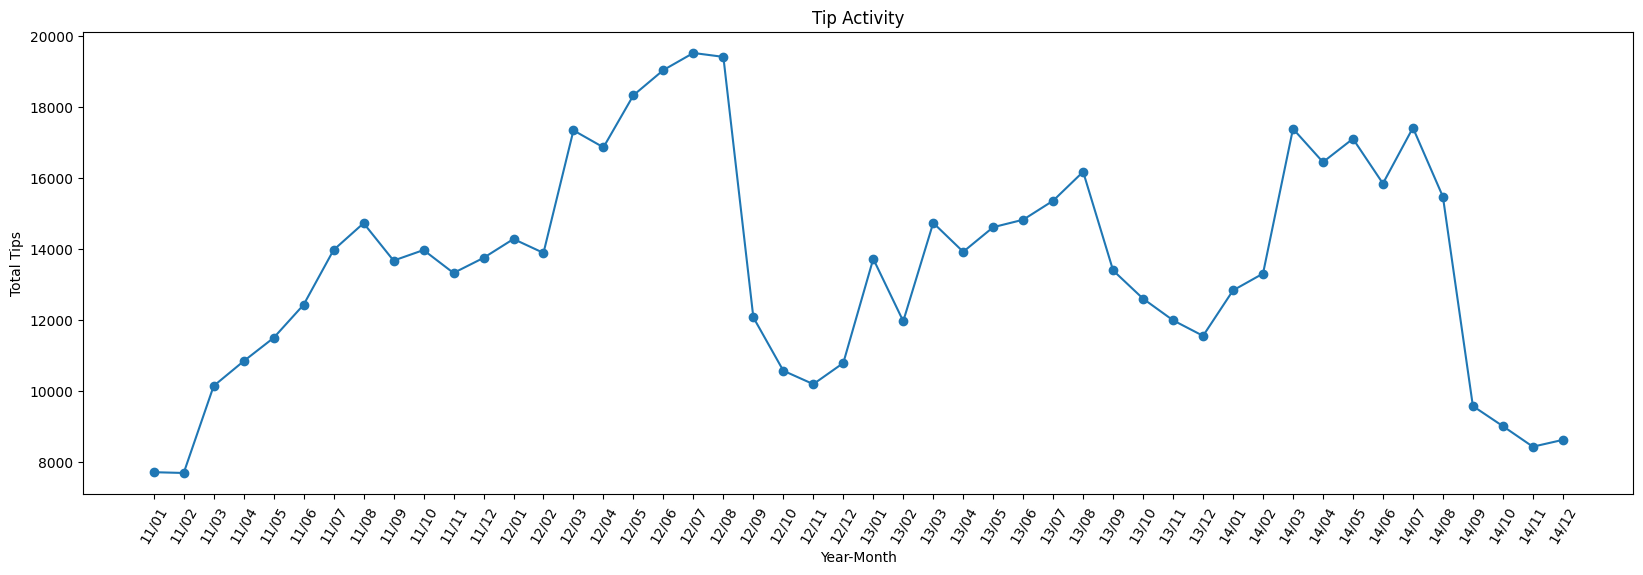

In [ ]:
# TODO: Visualize the yearly and monthly tip activity
x_axis = yearly_monthly_tips_df['year'].astype(str).str[-2:] + '/' + yearly_monthly_tips_df['month'] # Remove 20 as it's too long to display
plt.figure(figsize = (20, 6))
plt.plot(x_axis, 'total_tips', data = yearly_monthly_tips_df, marker = 'o', linestyle = '-')
plt.title('Tip Activity')
plt.xlabel('Year-Month')
plt.xticks(rotation=60)
plt.ylabel('Total Tips')
plt.show()

**Your Observations: The trend shows higher total tips in summer and a decline in winter. This suggests people dine out more in warm months due to vacations and outdoor activities, while colder weather and holiday spending may reduce dining out in winter.**

#### 2.2.2 Rolling Average of Monthly Business Reviews [7 points] (3 manually graded points)

Analyze **monthly review activity** to identify long-term patterns and fluctuations in user engagement.

**Note: Although this problem is quite involved in concept, the ultimate answer should not be long.**

**TODO**:
* Extract the **year** and **month** from the `date` column in `tip_cleaned_df`.
* Calculate the **total number of reviews left per month** **between 2014 and 2016**.
* Compute a **3-month rolling average** of reviews to smooth out fluctuations and highlight consistent trends.
* Round the rolling average to two decimal points.
* **Display**: `year`, `month`, `total_reviews`, `rolling_avg_reviews`.
* **Order the result by** `year` and `month` in ascending order.

**Hint**:
* Look into the SQL **window functions** (`ROWS BETWEEN`) to calculate the rolling average.
* The **rolling average** here takes the **current month's value**, along with the **two previous months' values**, and calculates their **average**.
* Understand the logic of how window functions like **`OVER`** work can help with the problem.
* **A valid 3-month rolling average** means that for a given row representing month `m`, the result is calculated as:

  $$ \text{Rolling Average} = \frac{\text{Value for Month } m + \text{Value for Month } (m-1) + \text{Value for Month } (m-2)}{3} $$

Save the final result as `monthly_review_trends_df`. Save your query as `query_review_trends`.

**Final Schema**:
>year | month | total_reviews | rolling_avg_reviews  
>--- | --- | --- | ---

In [ ]:
# TODO: Calculate total monthly reviews and compute rolling averages
query_monthly_reviews = '''
WITH monthly_reviews AS (
SELECT
  strftime(t.date, '%Y') AS year,
  strftime(t.date, '%m') AS month,
  COUNT(t.text) AS total_reviews
FROM tip_cleaned_df t
GROUP BY year, month
HAVING year BETWEEN '2014' AND '2016'
)
SELECT
  year,
  month,
  total_reviews,
  ROUND(AVG(total_reviews) OVER (ORDER BY year, month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW), 2) AS rolling_avg_reviews
FROM monthly_reviews
ORDER BY year ASC, month ASC
'''

# Execute query and save the result
monthly_review_trends_df = duckdb.sql(query_monthly_reviews).df().reset_index(drop=True)

In [ ]:
# 4 points
grader.grade(test_case_id='test_rolling_avg_monthly_reviews', answer = (query_monthly_reviews, monthly_review_trends_df))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, **visualize** the trend using a **line plot**. Include the trend for total reviews and rolling averages in two lines. Make sure to have the graph very clearly labeled. Briefly explain some potential advantages of using rolling averages from the graph. **[3 manually graded points]**

Your graph should have:

* Clear title and axis labels (Year-Month on X axis and Number of Reviews on Y axis)
* Two separate lines within one line plot with different labels
* Adequate figure size to show clearly the comparisons
* Adjusted spacing to prevent any figure overlappings

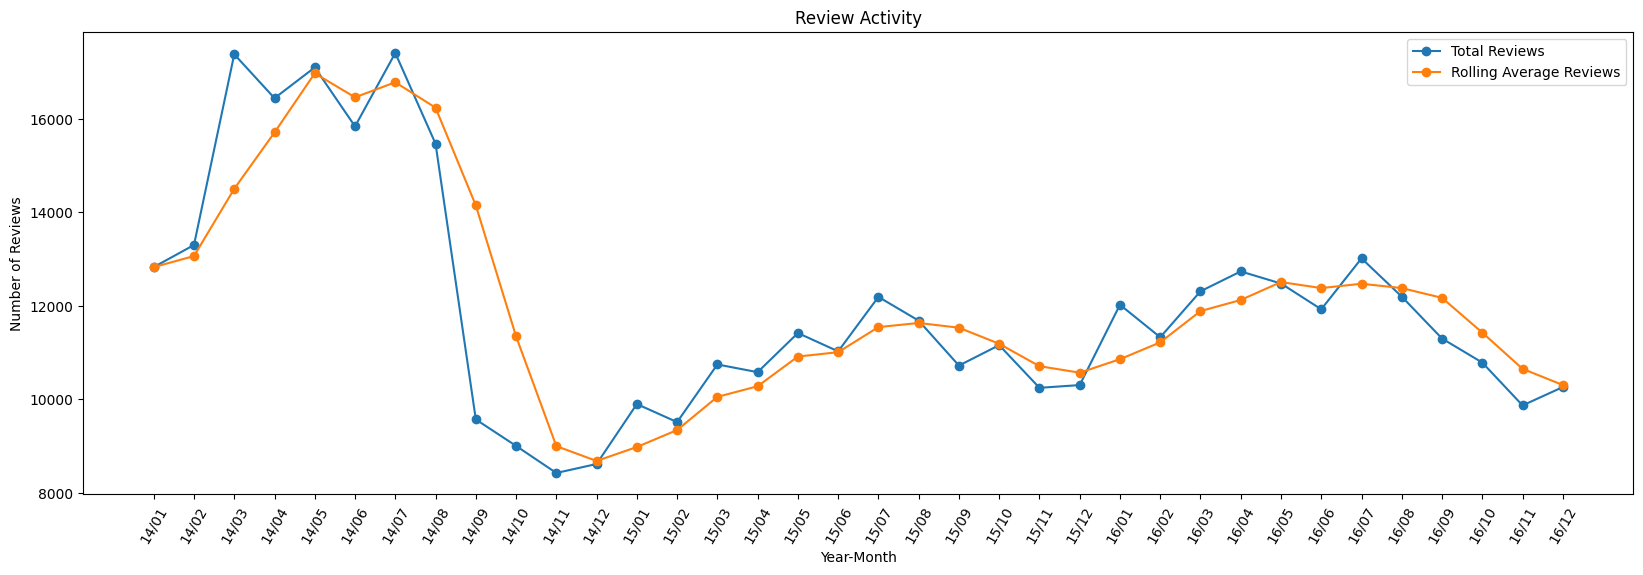

In [ ]:
# TODO: Visualize the trend of total reviews and rolling averages
x_axis = monthly_review_trends_df['year'].astype(str).str[-2:] + '/' + monthly_review_trends_df['month']
plt.figure(figsize = (20, 6))
plt.plot(x_axis, 'total_reviews', data = monthly_review_trends_df, marker = 'o', linestyle = '-')
plt.plot(x_axis, 'rolling_avg_reviews', data = monthly_review_trends_df, marker = 'o', linestyle = '-')
plt.title('Review Activity')
plt.xlabel('Year-Month')
plt.xticks(rotation=60)
plt.ylabel('Number of Reviews')
plt.legend(['Total Reviews', 'Rolling Average Reviews'])
plt.show()

**Your Observations: Rolling averages reduce noise from sudden spikes or drops, helping to identify the overall trend rather than being misled by local variations.**

### 2.3 Business Performance Analytics

#### 2.3.1 Identifying Top Restaurants by City [4 points]

In this question, we analyze the performance of restaurants across different cities using ratings, reviews, and check-ins. We would be first using `business_cleaned_df`.

**TODO**:
* Identify the **top 3 restaurants in each city** with the highest **average star ratings**.
  * Only include restaurants that have **more than 50 reviews** and are currently **open** (`is_open = 1`).
  * Display: `business_id`, `business_name`, `city`, `stars`, and `review_count`.
  * **Order the final result by** `city` in ascending order, `stars` in descending order, and `review_count` in descending order.

**Hint**:
* Use a CTE for calculation and then filter for the top 3 of each city.
* Use the **`ROW_NUMBER()`** window function to rank businesses within each city.

Save the final result as `top_restaurants_df`. Save your final query as `query_top_restaurant`.

**Final Schema**:
>business_id | business_name | city | stars | review_count  
>--- | --- | --- | --- | ---


In [ ]:
# TODO: Identify the top 3 restaurants in each city with >50 reviews and open
# CTE: Common Table Expression
query_top_restaurant = '''
WITH top_restaurants AS (
  SELECT
    business_id,
    name AS business_name,
    city,
    stars,
    review_count,
    ROW_NUMBER() OVER (
            PARTITION BY city
            ORDER BY stars DESC
        ) AS rank
  FROM business_cleaned_df
  WHERE review_count > 50 AND is_open = 1 AND is_restaurant = 1
)
SELECT
  business_id,
  business_name,
  city,
  stars,
  review_count
FROM top_restaurants
WHERE rank <= 3
ORDER BY city ASC, stars DESC, review_count DESC
'''

# Execute query and save the result
top_restaurants_df = duckdb.sql(query_top_restaurant).df().reset_index(drop=True)

In [ ]:
# 4 points
grader.grade(test_case_id='test_top_restaurants_by_city', answer=(query_top_restaurant, top_restaurants_df))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.2 Analyzing Check-In Performance [5 points]

Analyze the check-in performance of the top restaurants identified in **2.3.1**.

**TODO**:
* For each restaurant identified in **2.3.1**, calculate the **total number of check-ins** using the `checkin_cleaned_df` table.
* Compare each restaurant's total check-ins to the **average check-ins** of all restaurants in the same city.
* Use a **`CASE WHEN`** statement to label restaurants as `'Above Average'` or `'Below Average'` based on their total check-ins compared to the city average. Store it in `checkin_performance`.
* **Display**: `business_id`, `business_name`, `city`, `total_checkins`, `checkin_performance`.
* **Order the final result by** `checkin_performance` in ascending order and `total_checkins` in descending order.

**Hint**:
* First create a **CTE** that calculates the total check-ins for each business.
* You can look into the **CASE WHEN** function to label comparisons.

Save the final result as `checkin_performance_df`. Save the final query as `query_checkin_performace`.

**Final Schema**:
>business_id | business_name | city | total_checkins | checkin_performance  
>--- | --- | --- | --- | ---

In [ ]:
# TODO: Calculate total check-ins and compare with city average
query_checkin_performace ='''
WITH total_checkins_df AS (
  SELECT
    business_id,
    SUM(checkins) AS total_checkins
  FROM checkin_cleaned_df
  GROUP BY business_id
),
businessid_city_checkins_df AS (
  SELECT
    tcd.business_id,
    bcd.name AS business_name,
    bcd.city,
    tcd.total_checkins
  FROM total_checkins_df tcd
  JOIN business_cleaned_df bcd ON tcd.business_id = bcd.business_id
),
city_avg_checkins_df AS (
  SELECT
    city,
    ROUND(AVG(total_checkins), 3) AS avg_checkins
  FROM businessid_city_checkins_df
  GROUP BY city
),
half_df AS (
  SELECT
    bcd.business_id,
    bcd.business_name,
    bcd.city,
    bcd.total_checkins,
    CASE
      WHEN bcd.total_checkins > cacd.avg_checkins THEN 'Above Average'
      ELSE 'Below Average'
    END AS checkin_performance
  FROM businessid_city_checkins_df bcd
  JOIN city_avg_checkins_df cacd ON bcd.city = cacd.city
),
final_df AS (
  SELECT
    trd.business_id,
    trd.business_name,
    trd.city,
    hdf.total_checkins,
    hdf.checkin_performance
  FROM top_restaurants_df trd
  JOIN half_df hdf ON trd.business_id = hdf.business_id
)
SELECT *
FROM final_df
ORDER BY checkin_performance ASC, total_checkins DESC
'''

# Execute query and save the result
checkin_performance_df = duckdb.sql(query_checkin_performace).df().reset_index(drop=True)

In [ ]:
# 5 points
grader.grade(test_case_id='test_checkin_performance', answer=(query_checkin_performace, checkin_performance_df))

You earned 2/5 points.

The top five restaurant names are incorrect. Expected either: ['Cornish Pasty', 'Sakanaya Restaurant', 'Poke Express', 'Happy Dog', 'Smash Kitchen & Bar'] or ['Four Peaks Brewing', 'Brew Tea Bar', 'Cornish Pasty', 'Postino East', 'Settebello Pizzeria Napoletana'], but got: ['In-N-Out Burger', 'Sakanaya Restaurant', 'Poke Express', 'Happy Dog', 'Hummus Xpress'].
The top five check-in counts are incorrect. Expected either: [5019.0, 2372.0, 2102.0, 1940.0, 1642.0] or [12703.0, 11123.0, 5019.0, 3746.0, 3053.0], but got: [4273.0, 2372.0, 2102.0, 1940.0, 1910.0].
Don't worry, you can re-submit and we will keep only your latest score.


#### 2.3.3 Analyzing Review Trends Over Time [5 points]

Analyze how the **number of reviews** for the top restaurants identified in **2.3.1** has changed over time using the `tip_cleaned_df` table.

**TODO**:
* For each restaurant identified in **2.3.1**, **count the number of reviews per year** using the `tip_cleaned_df` table.
* **Filter** the results to include only restaurants located in **Paradise Valley** and in the years **2013 to 2017**.
* Compare the number of reviews year-over-year to determine if review activity is **increasing**, **decreasing**, or **stable**.
* Label each year's trend as `'Increasing'`, `'Decreasing'`, or `'Stable'` based on comparison with the previous year. (If there is no data for the previous year, label the trend as 'Stable')
* **Display**: `business_id`, `business_name`, `year`, `review_count`, `review_trend`.
* **Order the final result by** `business_name` and `year` in ascending order.

**Hint**:
* Create a **CTE** to count reviews per year for each restaurant.
* Use **`CAST(strftime(tip_cleaned_df.date, '%Y') AS INTEGER)`** to extract and filter the year from the review date.
* Look into the **`LAG()`** window function to compare the current year's review count with the previous year's.
* Use **`CASE WHEN()`** to determine trend

Save the final result as `review_trends_df`. Save the final query as `query_review_trends`.

**Final Schema**:
>business_id | business_name | year | review_count | review_trend  
>--- | --- | --- | --- | ---

In [ ]:
# TODO: Analyze review trends over time
query_review_trends = '''
WITH review_counts AS (
  SELECT
    t.business_id,
    r.business_name,
    CAST(strftime(t.date, '%Y') AS INTEGER) AS year,
    COUNT(t.text) AS review_count,
    r.city
  FROM tip_cleaned_df t
  INNER JOIN top_restaurants_df r ON t.business_id = r.business_id
  WHERE city = 'Paradise Valley' AND year BETWEEN 2013 AND 2017
  GROUP BY t.business_id, r.business_name, r.city, year

)
SELECT
  business_id,
  business_name,
  year,
  review_count,
  CASE
    WHEN review_count > LAG(review_count) OVER (PARTITION BY business_id ORDER BY year) THEN 'Increasing'
    WHEN review_count < LAG(review_count) OVER (PARTITION BY business_id ORDER BY year) THEN 'Decreasing'
    ELSE 'Stable'
  END AS review_trend
FROM review_counts
'''

# Execute query and save the result
review_trends_df = duckdb.sql(query_review_trends).df().reset_index(drop=True)

In [ ]:
# 5 points
grader.grade(test_case_id='test_review_trends', answer=(query_review_trends, review_trends_df))

You earned 3/5 points.

Review trends for 'El Chorro' are incorrect. Expected: ['Stable', 'Decreasing', 'Increasing'], but got: [].
Don't worry, you can re-submit and we will keep only your latest score.


#### 2.3.4 Analyzing Tip-to-Check-In Ratio [8 points]

Create a dataframe to analyze the restaurants in the Yelp Database with the 10 highest tip-to-check-in ratio. This is to analyze which restaurants and cities have very high engagement online compared to its number of check ins. This might imply an area with a lot of Yelp presence.


**TODO:**

- For each business, **calculate the total number of tips** using the `tip_cleaned_df` table.
- For each business, **calculate the total number of check-ins** using the `checkin_cleaned_df` table.
- **Join** these results with the `business_cleaned_df` table to obtain the business name and city.
- **Compute** the engagement ratio for each business by dividing the total tip count by the total check-in count.  
  - **Note:** Use a `CASE WHEN` statement to handle cases with zero check-ins by setting the ratio to 0.
- **Aggregate** the engagement ratio for each city to calculate the average engagement ratio per city.
- For each business, **compare** its engagement ratio to the city average:
  - Label the business as `'High Engagement'` if its ratio is at least 10% above the city average.
  - Label it as `'Low Engagement'` if its ratio is at least 10% below the city average.
  - Otherwise, label it as `'Average Engagement'`.
- **Display** the final result with the following columns:  
  `business_id`, `business_name`, `city`, `tip_count`, `checkin_count`, `tip_checkin_ratio`, `city_avg_ratio`, `engagement_label`.
- **Order** the final result by `tip_checkin_ratio` (descending) and keep the top 10. Ensure that `tip_checkin_ratio` and `city_average_ratio` is rounded to 3 decimal digits. Filter out any restaurants with `tip_count` less than or equal to 200

**Hint:**

- Create a **CTE** to aggregate tip counts from `tip_cleaned_df`.
- Create another **CTE** to aggregate check-in counts from `checkin_cleaned_df`.
- Join these CTEs with `business_cleaned_df` to form a business-level engagement table. Think about what type of join.
* **MAKE SURE TO HANDLE THE NULL VALUES BY MAKING IT 0, AND IF `CHECK_IN_COUNT` IS 0, THEN SET TIP_CHECKIN_RATIO OF THAT PLACE TO 0, ELSE ROUND IT** to 3 decimal digits
- Use a **CTE** to calculate the city-level average engagement ratio.
- Apply a **CASE WHEN** statement to compare each business’s ratio against its city average.
- Save the final result as `engagement_performance_df` and the final query as `query_engagement_performance`.

**Final Schema:**

| business_id | business_name | city | tip_count | checkin_count | tip_checkin_ratio | city_avg_ratio | engagement_label |
| ----------- | ------------- | ---- | --------- | ------------- | ----------------- | -------------- | ---------------- |

In [ ]:
tip_to_check_in = '''
WITH tip_counts AS (
  SELECT
    business_id,
    COUNT(*) AS tip_count
  FROM tip_cleaned_df
  GROUP BY business_id
),
checkin_counts AS (
  SELECT
    business_id,
    COUNT(checkins) AS checkin_count
  FROM checkin_cleaned_df
  GROUP BY business_id
),
business_engagement AS (
  SELECT
    bcd.business_id,
    bcd.name AS business_name,
    bcd.city,
    COALESCE(tc.tip_count, 0) AS tip_count,
    COALESCE(cc.checkin_count, 0) AS checkin_count,
    CASE
      WHEN COALESCE(cc.checkin_count, 0) = 0 THEN 0
      ELSE ROUND(tc.tip_count / cc.checkin_count, 3)
    END AS tip_checkin_ratio
  FROM business_cleaned_df bcd
  LEFT JOIN tip_counts tc ON bcd.business_id = tc.business_id
  LEFT JOIN checkin_counts cc ON bcd.business_id = cc.business_id
  WHERE bcd.is_restaurant = 1
),
city_avg AS (
  SELECT
    city,
    ROUND(AVG(tip_checkin_ratio), 3) AS city_avg_ratio
  FROM business_engagement
  GROUP BY city
),
final_engagement AS (
  SELECT
    be.business_id,
    be.business_name,
    be.city,
    be.tip_count,
    ROUND(be.checkin_count, 3) AS checkin_count,
    ROUND(be.tip_checkin_ratio, 3) AS tip_checkin_ratio,
    ca.city_avg_ratio,
    CASE
      WHEN be.tip_checkin_ratio >= 1.1 * ca.city_avg_ratio THEN 'High Engagement'
      WHEN be.tip_checkin_ratio <= 0.9 * ca.city_avg_ratio THEN 'Low Engagement'
      ELSE 'Average Engagement'
    END AS engagement_label
  FROM business_engagement be
  LEFT JOIN city_avg ca ON be.city = ca.city
  WHERE be.tip_count > 200
)
SELECT *
FROM final_engagement
ORDER BY tip_checkin_ratio DESC
LIMIT 10
'''

tip_to_check_in_df = duckdb.sql(tip_to_check_in).df().reset_index(drop=True)

In [ ]:
# 8 points
grader.grade(test_case_id='test_tip_checkin', answer=(tip_to_check_in_df))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.5 Identify users who review businesses with low tips. [5 points]

**TODO**:
* Keep businesses with less than 3 tips and greater than 100 reviews.
* Idenfity users who have reviewed these businesses and calculate the number of reviews they have placed on these businesses as `num_reviews`.
* Order the final result by `num_reviews` in descending order, and `user_name` in ascending order.

**Hint**:
* Create multiple **CTE**'s.

Save the final result as `niche_reviewers_df`.

**Final Schema**:
>user_id | user_name | num_reviews
>--- | --- | ---

In [ ]:
query_niche_reviewers = '''
WITH business_filtered AS (
  SELECT
    tcd.business_id,
    bcd.review_count,
    COUNT(tcd.text) AS tip_count
  FROM tip_cleaned_df tcd
  LEFT JOIN business_cleaned_df bcd ON tcd.business_id = bcd.business_id
  GROUP BY tcd.business_id, bcd.review_count
  HAVING COUNT(tcd.text) < 3 AND bcd.review_count > 100
),
user_reviews AS (
  SELECT
    tcd.user_id,
    COUNT(tcd.text) AS num_reviews
  FROM business_filtered bf
  LEFT JOIN tip_cleaned_df tcd ON bf.business_id = tcd.business_id
  GROUP BY tcd.user_id
)
SELECT
  ur.user_id,
  u.name AS user_name,
  ur.num_reviews
FROM user_reviews ur
LEFT JOIN user_df u ON ur.user_id = u.user_id
ORDER BY ur.num_reviews DESC, u.name ASC
'''

niche_reviewers_df = duckdb.sql(query_niche_reviewers).df().reset_index(drop=True)

In [ ]:
# 5 points
grader.grade(test_case_id='test_niche_reviewers', answer=niche_reviewers_df)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Part 3: Schema Design [25 points manually graded]

## 3.1 Functional Dependencies (5 points manually graded)


Let  $A, B, C, D, E, F$  all be attributes in our schema.

Use Armstrong's axioms to prove that if:

$AB \rightarrow C$, $C \rightarrow D$, $DE \rightarrow F$, and $E \rightarrow B$, then $AE \rightarrow F$.

Review Lecture 6 (Relational schema) slide 50 if you need a refresher on Armstrong's axioms.

$$
\begin{aligned}
\text{Step 1:} & \quad E  \rightarrow B  & \quad \text{(given)}           \\
\text{Step 2:} & \quad AE \rightarrow AB & \quad \text{(augm 1 with A)}   \\
\text{Step 3:} & \quad AB \rightarrow C  & \quad \text{(given)}           \\
\text{Step 4:} & \quad C  \rightarrow D  & \quad \text{(given)}           \\
\text{Step 5:} & \quad AE \rightarrow D  & \quad \text{(trans 3+4)}       \\
\text{Step 6:} & \quad AE \rightarrow DE & \quad \text{(augm 5 with E)}   \\
\text{Step 7:} & \quad DE \rightarrow F  & \quad \text{(given)}           \\
\text{Step 8:} & \quad AE \rightarrow F  & \quad \text{(trans 6+7)}
\end{aligned}
$$


## 3.2 3NF (10 points manually graded)


**Please answer the following question in the markdown cell below.**

Suppose $R = {A, B, C, D, E}$, and we have the following set of functional dependencies:

$A \rightarrow BC$

$B \rightarrow C$

$B \rightarrow D$

$C \rightarrow E$

Decompose $R$ into third normal form (3NF). Clearly mark the relations in your final answer, and specify their primary key.

$$
\begin{aligned}
& A  \rightarrow BC \quad \Rightarrow \quad A  \rightarrow B, \quad A  \rightarrow C \\
& \{A  \rightarrow B, A  \rightarrow C, B  \rightarrow C, B  \rightarrow D, C \rightarrow E\} \\
\\
& \text{Decomposed Relations in 3NF:} \\
& \begin{array}{ccl}
(A, B, C)  & \quad \text{Primary Key:} & A  \\
(B, D)     & \quad \text{Primary Key:} & B  \\
(C, E)     & \quad \text{Primary Key:} & C
\end{array}
\end{aligned}
$$


## 3.3 Entity Relationship Design (10 points manually graded)


**Please answer the following question in the markdown cell below by uploading an image of your solution. You can do this by:**


1. Upload images from your local machine by clicking on the files icon in the left sidebar
2. Click the **Upload** button
3. Select the image you want to upload after the file upload dialogue appears

GO EAGLES!!! Consider a NFL database that must be designed to manage players, coaches, and subteams. The system should be designed to capture the following requirements:

1. Every player has a unique player ID (e.g. 033), name (e.g. Cooper DeJean), position (cornerback), and age (22).
2. Every subteam has a unique subteam ID (e.g. 002), subteam code (e.g. Eagles-D1), and name (e.g. Eagles Defensive Unit A).
3. Each coach has a unique coach ID (e.g. 007), name (e.g. Vic Fangio), and title (e.g. Defensive Coordinator).
4. Players can be in multiple subteams.
5. Each subteam can have just one coach, but a coach can lead multiple subteams.

Carefully consider the relationships that exist between players and subteams, and subteams and coaches.

Design an ER diagram that captures the relationships above. Be sure to capture all entities, relationships, and cardinalities.

In [ ]:
# Mount drive to give colab access to your other files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


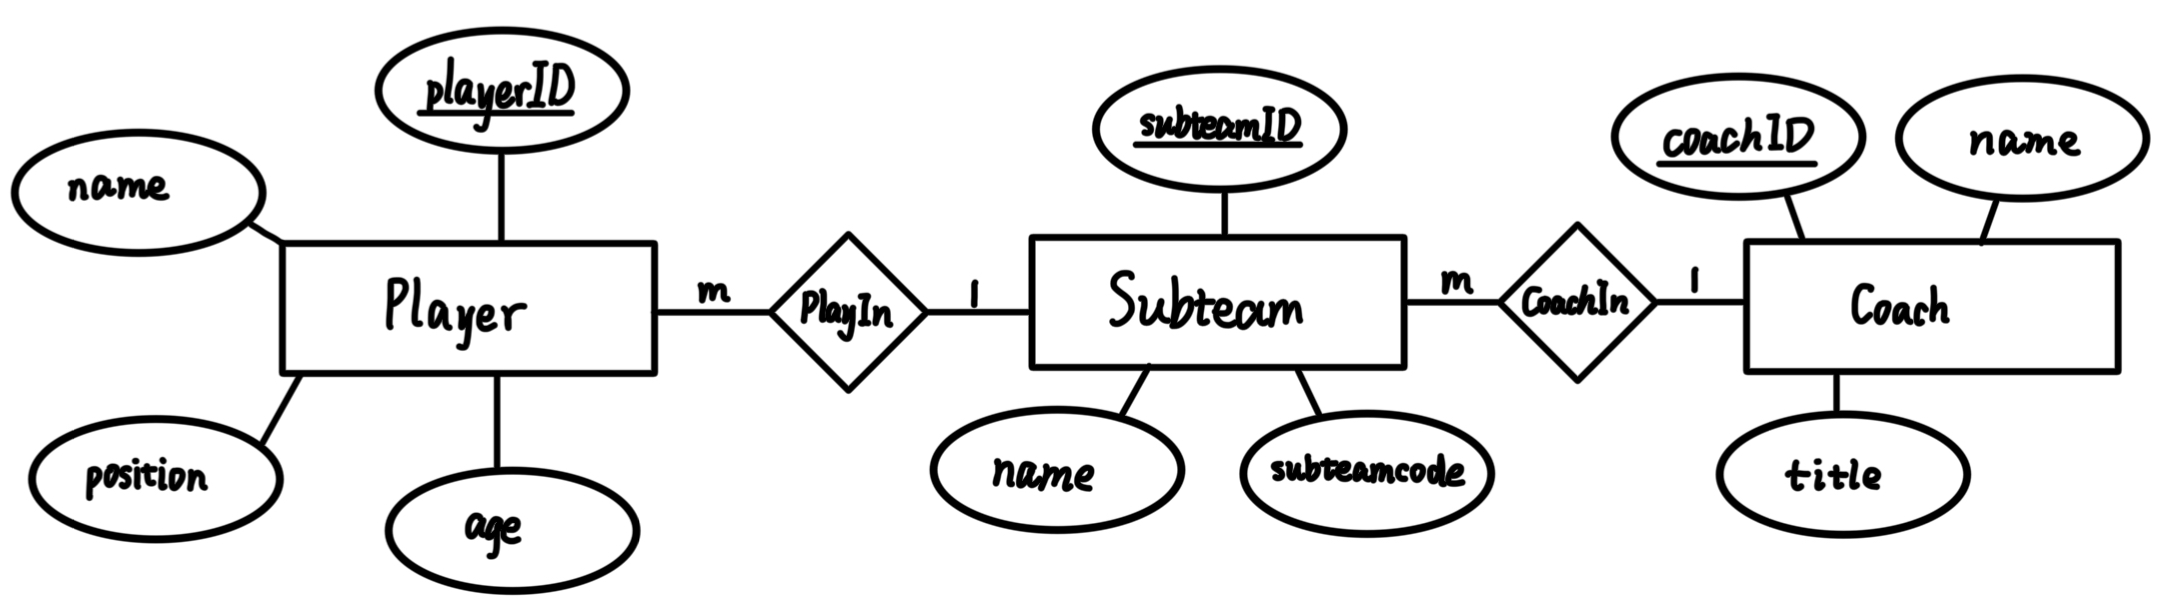

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('HW2ER.jpg')
img.show()
display(img)

# HW Submission

Before you submit on Gradescope (you must submit your notebook to receive credit):


1.   Restart and Run-All to make sure there's nothing wrong with your notebook
2.   **Double check that you have the correct PennID (all numbers) in the autograder**.
3. Make sure you've run all the PennGrader cells
4. Go to the "File" tab at the top left, and download both the .ipynb and .py files, renaming them as "homework2.ipynb" and "homework2.py" respectively. Upload both files to Gradescope directly!
5. Check your .ipynb file is visible under the code tab. If there is a "large file error" go back and delete all occurances of printing an entire df, and/or make your figure sizes smaller, then resubmit. Then confirm the notebook preview is now visible in your Gradescope submission.

**You MUST check that your notebook displays ALL visualizations on the Gradescope preview AND verify that the autograder finishes running and gives you your expected score (not a 0).**

**Let the course staff know ASAP if you have any issues submitting, but otherwise best of luck! Congrats on finishing the HW.**